#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [ ]:
!pip install pydrive2

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [ ]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"




Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

## Importación de librerías necesarias para el notebook

In [ ]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Ejemplo de salida de una imágen luego de aplicada la transformación Canny

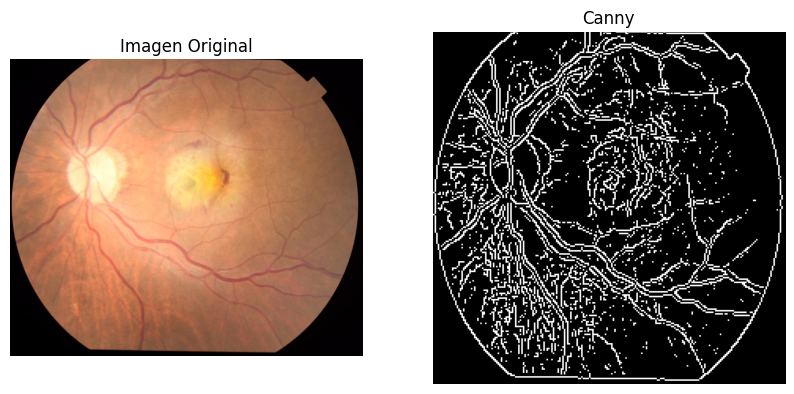

In [ ]:
image_path = '/content/DS_TFE_Final/test/Macular_Scar/Macular Scar125-flip.jpg'
image = cv2.imread(image_path)

# Comprobar y convertir el tipo de la imagen a uint8 si es necesario

image1 = cv2.resize(image, (224,224))
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image1 = cv2.Canny(image1, 40, 40)

# Mostrar la imagen original y la imagen con Canny
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Canny')
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [ ]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

## Visualizamos algunas de las imagenes del dataset

In [ ]:
def show_6_images(vector_imagenes, filtro, titulo):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10,10), subplot_kw={'xticks':[], 'yticks':[]})
  for i, ax in enumerate(axes.flat):
      img = cv2.imread(vector_imagenes[i])
      img = cv2.resize(img, (220,220))
      if (filtro =="Canny"):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.Canny(img, 80, 100)
      ax.imshow(img)
      ax.set_title(titulo)
  fig.tight_layout()
  plt.show()

Función para convertir la imágen aplicando el filtro Canny.
Esta función se ejecuta al momento de procesar las imagenes en el entrenamiento mediante el ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocessing_image(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if gray_image.dtype != np.uint8:
        gray_image = (255 * (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))).astype(np.uint8)

    # Aplicar el filtro Canny
    edges = cv2.Canny(gray_image, 40, 40)

    # Convertir la imagen de bordes a BGR (3 canales)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Redimensionar la imagen al tamaño esperado por el modelo
    edges_resized = cv2.resize(edges_colored, (224, 224))

    # Preprocesar la imagen para ResNet50V2
    edges_preprocessed = preprocess_input(edges_resized)

    return edges_preprocessed


## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

input_shape = (224, 224,3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1


In [ ]:
base_model1 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model1.layers:
    layer.trainable = False


model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='softmax'))
model1.summary()

model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 6)                 774       
                                                                 
Total params: 7169478 (27.35 MB)
Trainable params: 131974 (515.52 KB)
Non-trainable params: 7037504 (26.85 MB)
_________

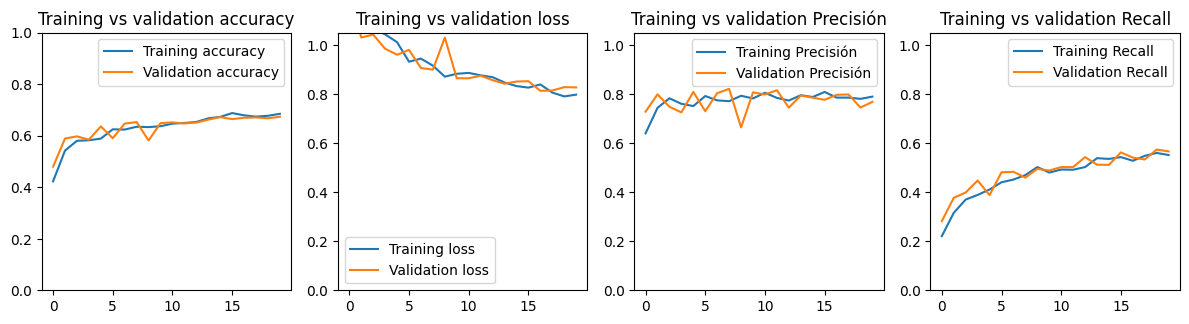

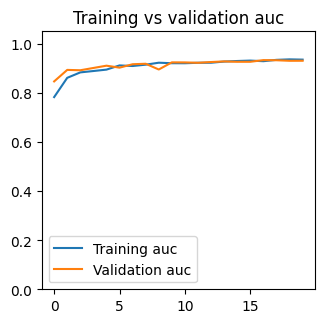

In [ ]:
graph(history1)

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)

39/39 [==============================] - 13s 343ms/step


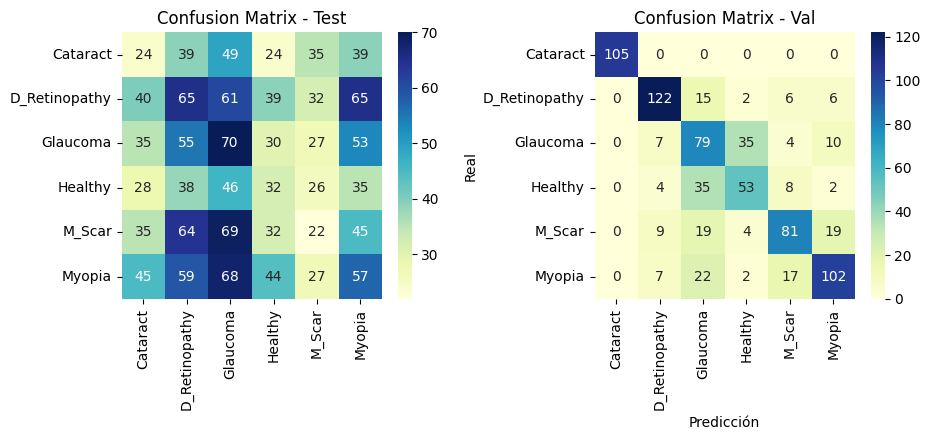

In [ ]:
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1, y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1, y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.11      0.12       210
           1       0.20      0.22      0.21       302
           2       0.19      0.26      0.22       270
           3       0.16      0.16      0.16       205
           4       0.13      0.08      0.10       267
           5       0.19      0.19      0.19       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.82      0.81      0.81       151
           2       0.46      0.59      0.52       135
           3       0.55      0.52      0.54       102
           4       0.70      0.61      0.65       132
           5       0.73      0.68      0.71       150

    accuracy                           0.70       775
   macro avg       0.71

## Modelo 4

In [ ]:
base_model4 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 7333574 (27.98 MB)
Trainable params: 296070

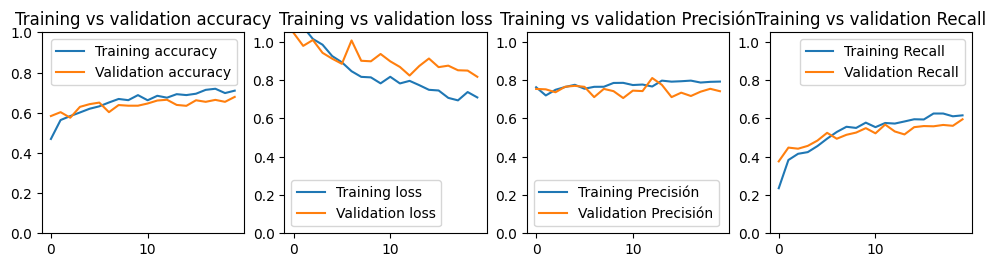

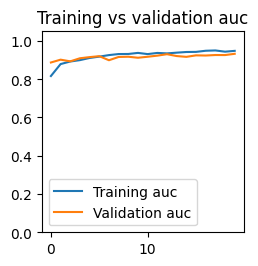

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 17s 436ms/step


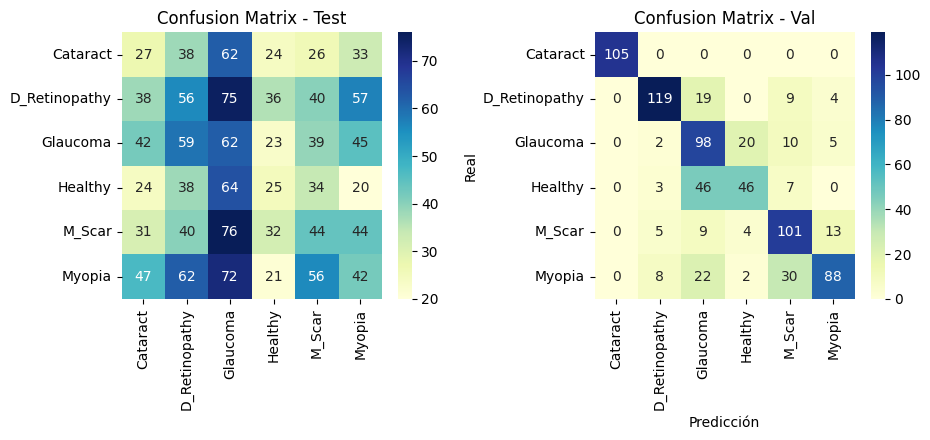

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.19      0.19      0.19       302
           2       0.15      0.23      0.18       270
           3       0.16      0.12      0.14       205
           4       0.18      0.16      0.17       267
           5       0.17      0.14      0.16       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.87      0.79      0.83       151
           2       0.51      0.73      0.60       135
           3       0.64      0.45      0.53       102
           4       0.64      0.77      0.70       132
           5       0.80      0.59      0.68       150

    accuracy                           0.72       775
   macro avg       0.74

## Modelo 5

In [ ]:
base_model5 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model5.layers:
    layer.trainable = False


model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))
model5.summary()

model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 2056)              2107400   
                                                                 
 dense_4 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

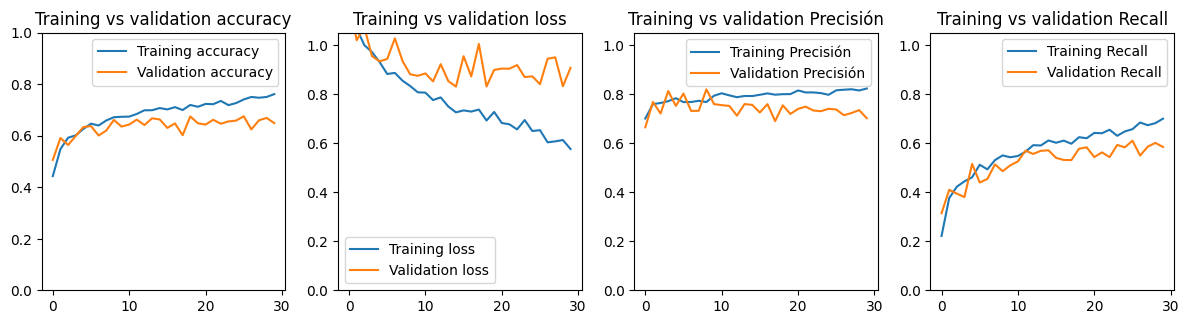

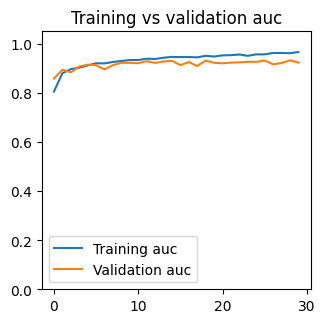

In [ ]:
graph(history5)

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)

39/39 [==============================] - 13s 333ms/step


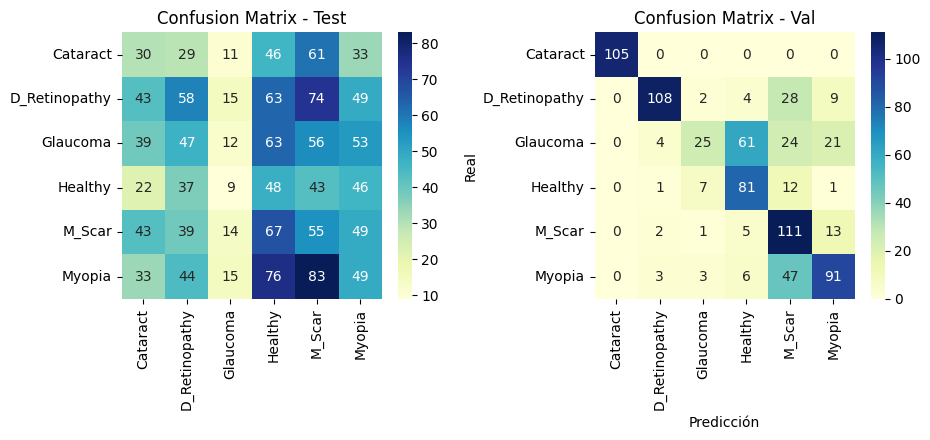

In [ ]:
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.23      0.19      0.21       302
           2       0.16      0.04      0.07       270
           3       0.13      0.23      0.17       205
           4       0.15      0.21      0.17       267
           5       0.18      0.16      0.17       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.92      0.72      0.80       151
           2       0.66      0.19      0.29       135
           3       0.52      0.79      0.63       102
           4       0.50      0.84      0.63       132
           5       0.67      0.61      0.64       150

    accuracy                           0.67       775
   macro avg       0.71

## Modelo 15

In [ ]:
base_model15 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model15.layers:
    layer.trainable = False


model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 2056)              2107400   
                                                                 
 dense_9 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                      

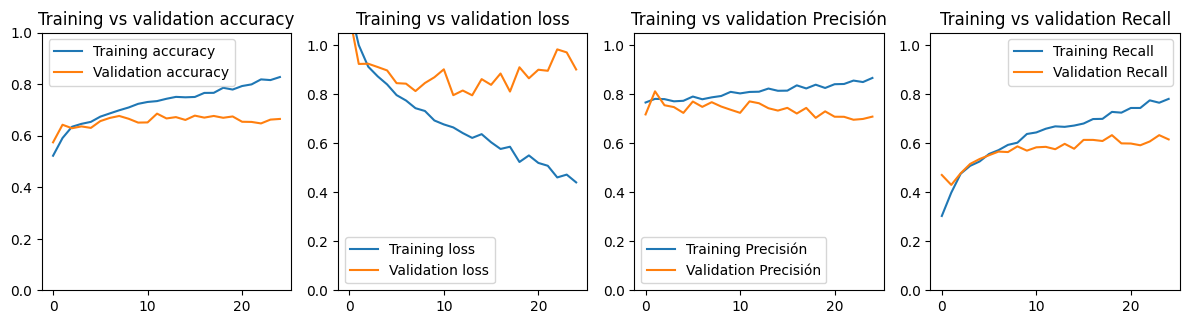

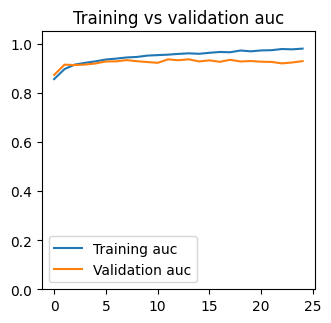

In [ ]:
graph(history15)

39/39 [==============================] - 13s 348ms/step


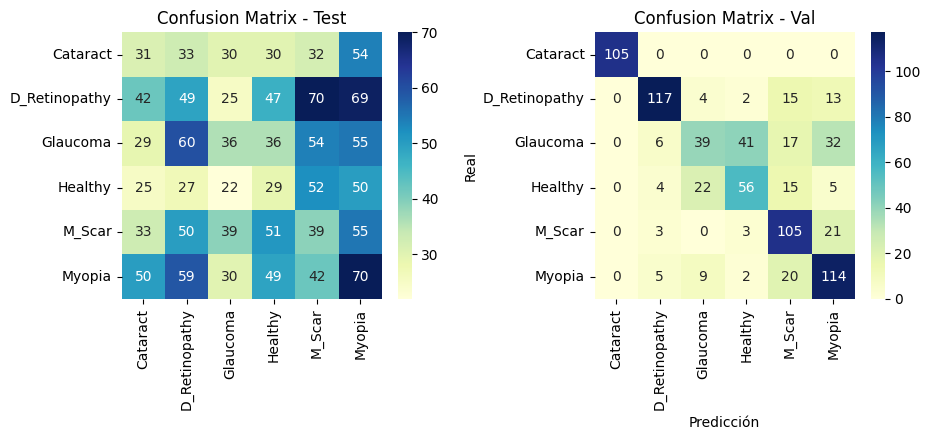

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.18      0.16      0.17       302
           2       0.20      0.13      0.16       270
           3       0.12      0.14      0.13       205
           4       0.13      0.15      0.14       267
           5       0.20      0.23      0.21       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.87      0.77      0.82       151
           2       0.53      0.29      0.37       135
           3       0.54      0.55      0.54       102
           4       0.61      0.80      0.69       132
           5       0.62      0.76      0.68       150

    accuracy                           0.69       775
   macro avg       0.69

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 2056)              2107400   
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                      

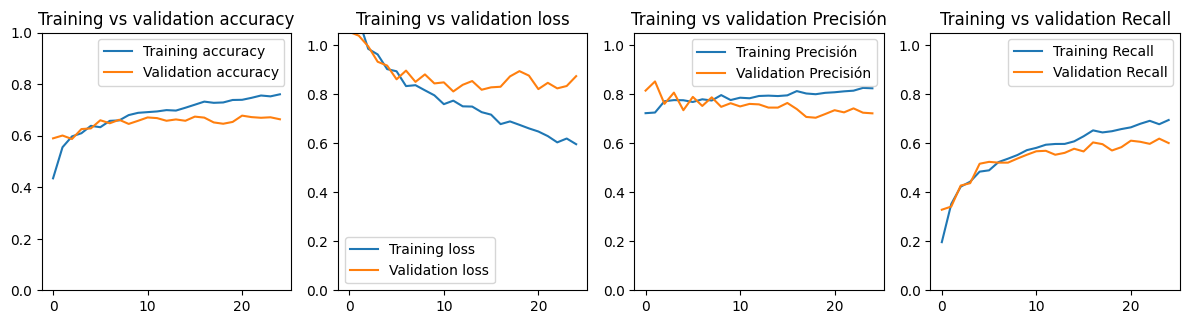

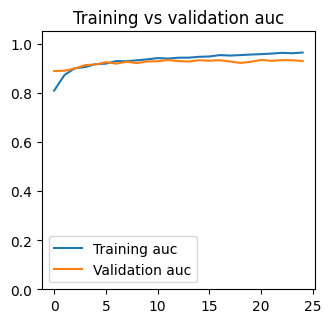

In [ ]:
graph(history16)

39/39 [==============================] - 14s 360ms/step


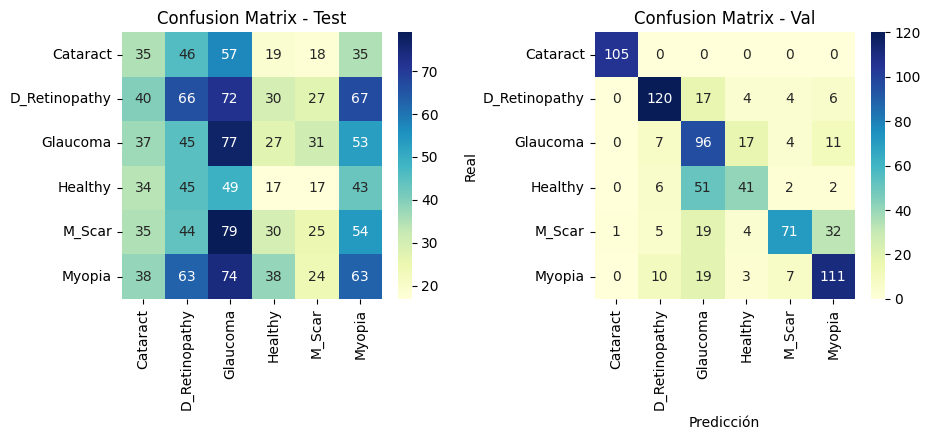

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.17      0.16       210
           1       0.21      0.22      0.22       302
           2       0.19      0.29      0.23       270
           3       0.11      0.08      0.09       205
           4       0.18      0.09      0.12       267
           5       0.20      0.21      0.20       300

    accuracy                           0.18      1554
   macro avg       0.17      0.18      0.17      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.81      0.79      0.80       151
           2       0.48      0.71      0.57       135
           3       0.59      0.40      0.48       102
           4       0.81      0.54      0.65       132
           5       0.69      0.74      0.71       150

    accuracy                           0.70       775
   macro avg       0.73

## Modelo 6

In [ ]:
base_model6 = tf.keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 5112)              5239800   
                                                                 
 dense_19 (Dense)            (None, 2056)              10512328  
                                                                 
 dense_20 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                      

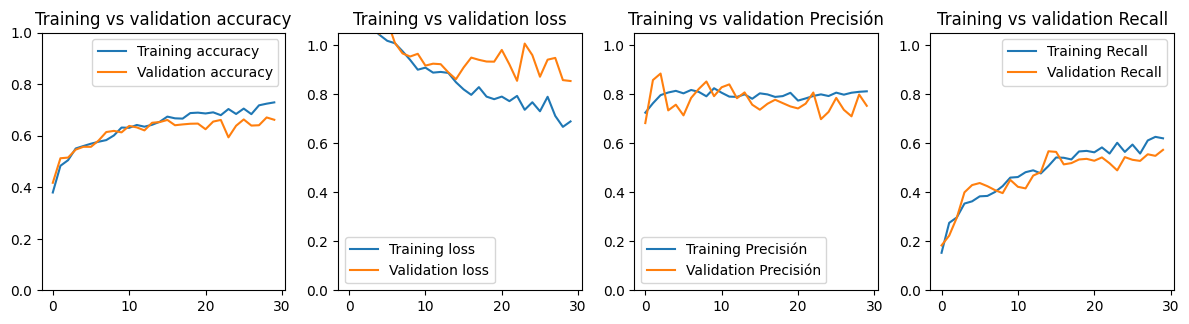

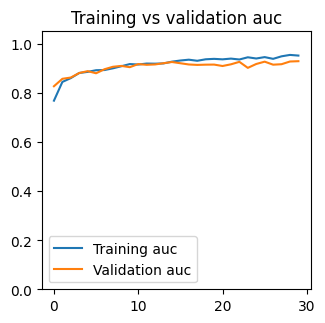

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 13s 340ms/step


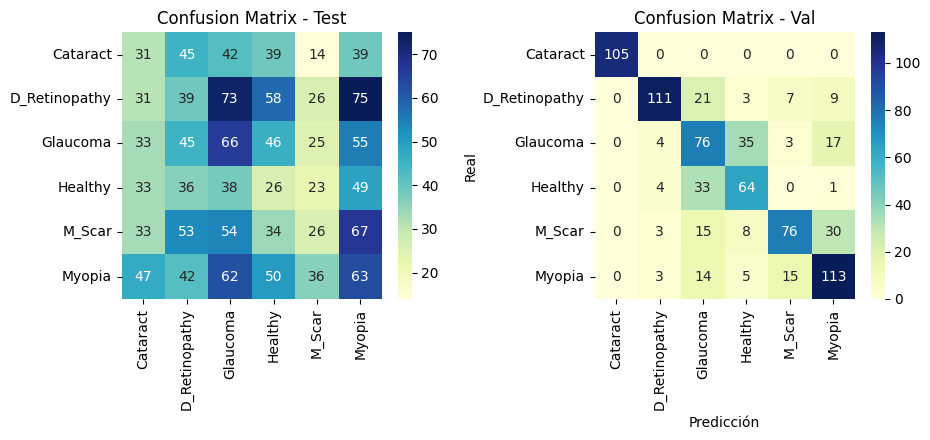

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.15      0.13      0.14       302
           2       0.20      0.24      0.22       270
           3       0.10      0.13      0.11       205
           4       0.17      0.10      0.12       267
           5       0.18      0.21      0.19       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.89      0.74      0.80       151
           2       0.48      0.56      0.52       135
           3       0.56      0.63      0.59       102
           4       0.75      0.58      0.65       132
           5       0.66      0.75      0.71       150

    accuracy                           0.70       775
   macro avg       0.72

## Modelo 20


In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

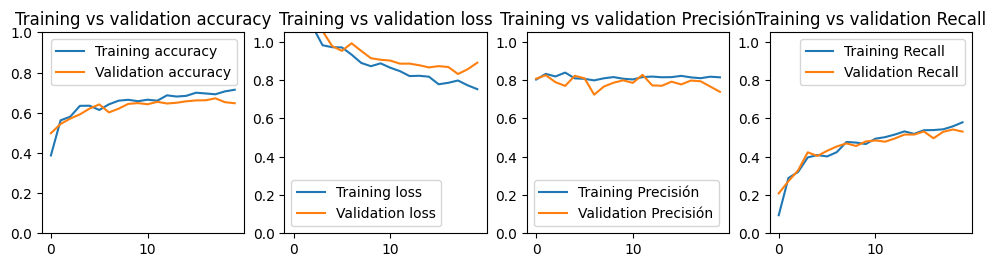

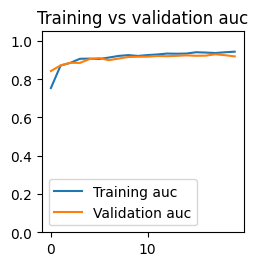

In [ ]:
graph(history_dense)

39/39 [==============================] - 16s 430ms/step


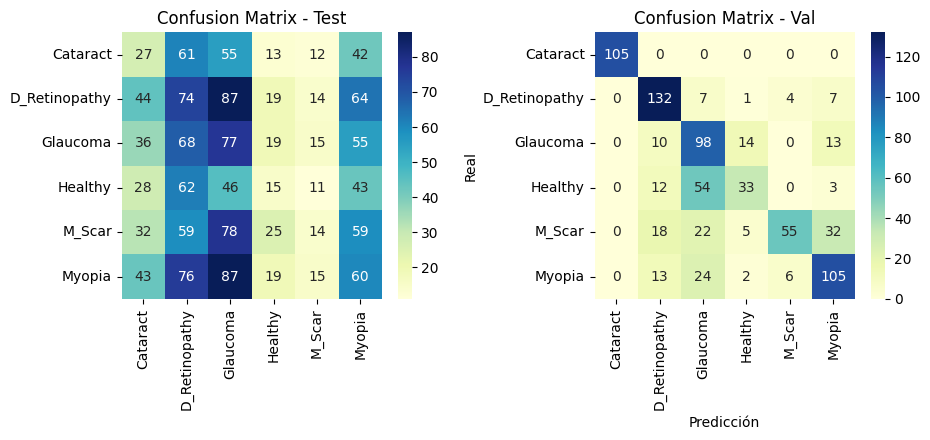

In [ ]:
y_pred_test = model.predict(test_generator)
y_pred_val = model.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.18      0.25      0.21       302
           2       0.18      0.29      0.22       270
           3       0.14      0.07      0.10       205
           4       0.17      0.05      0.08       267
           5       0.19      0.20      0.19       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.17      0.17      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.71      0.87      0.79       151
           2       0.48      0.73      0.58       135
           3       0.60      0.32      0.42       102
           4       0.85      0.42      0.56       132
           5       0.66      0.70      0.68       150

    accuracy                           0.68       775
   macro avg       0.72

## Modelo 19

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 89s 526ms/step - loss: 1.5596 - accuracy: 0.3362 - precision: 0.7406 - recall: 0.0792 - auc: 0.7122 - val_loss: 1.2623 - val_accuracy: 0.4672 - val_precision: 0.8571 - val_recall: 0.1467 - val_auc: 0.8350
Epoch 2/25
150/150 [==============================] - 79s 525ms/step - loss: 1.3106 - accuracy: 0.4343 - precision: 0.7262 - recall: 0.1910 - auc: 0.8093 - val_loss: 1.1637 - val_accuracy: 0.5148 - val_precision: 0.7630 - val_recall: 0.2651 - val_auc: 0.8586
Epoch 3/25
150/150 [==============================] - 93s 621ms/step - loss: 1.2313 - accuracy: 0.4783 - precision: 0.7229 - recall: 0.2557 - auc: 0.8357 - val_loss: 1.1235 - val_accuracy: 0.5129 - val_precision: 0.7143 - val_recall: 0.2896 - val_auc: 0.8668
Epoch 4/25
150/150 [==============================] - 76s 510ms/step - loss: 1.1542 - accuracy: 0.5184 - precision: 0.7429 - recall: 0.2975 - auc: 0.8574 - val_loss: 1.0761 - val_accuracy: 0.5534 - val_precision: 0.7760 - v

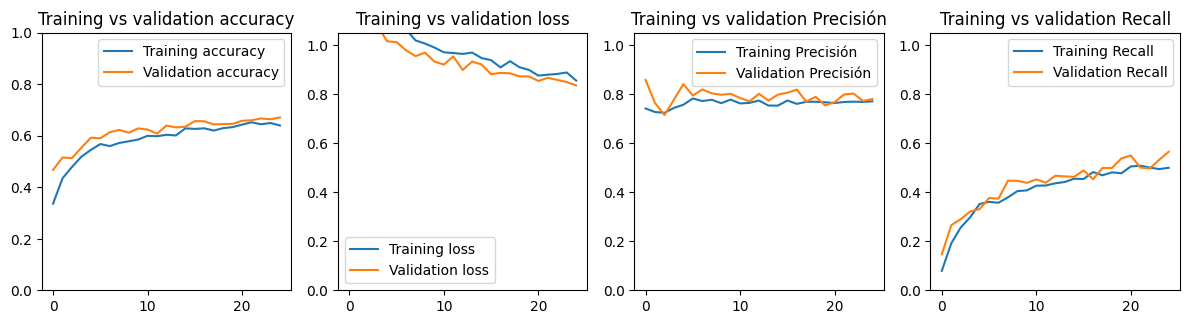

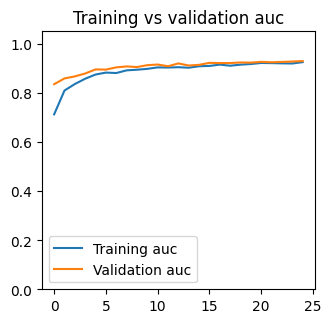

In [ ]:
graph(history19)

39/39 [==============================] - 13s 339ms/step


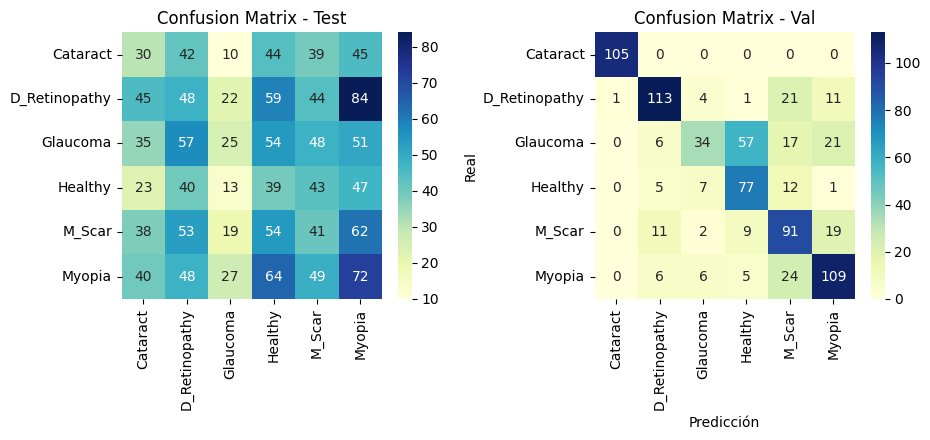

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.17      0.16      0.16       302
           2       0.22      0.09      0.13       270
           3       0.12      0.19      0.15       205
           4       0.16      0.15      0.15       267
           5       0.20      0.24      0.22       300

    accuracy                           0.16      1554
   macro avg       0.17      0.16      0.16      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.80      0.75      0.77       151
           2       0.64      0.25      0.36       135
           3       0.52      0.75      0.61       102
           4       0.55      0.69      0.61       132
           5       0.68      0.73      0.70       150

    accuracy                           0.68       775
   macro avg       0.70

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 88s 321ms/step - loss: 0.7354 - accuracy: 0.6940 - precision: 0.7982 - recall: 0.5911 - auc: 0.9452
Evaluar con Validación:
78/78 [==============================] - 27s 343ms/step - loss: 0.8265 - accuracy: 0.6731 - precision: 0.7677 - recall: 0.5656 - auc: 0.9305
Evaluar con Prueba:
39/39 [==============================] - 15s 396ms/step - loss: 0.7212 - accuracy: 0.6994 - precision: 0.7962 - recall: 0.5897 - auc: 0.9472


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 96s 354ms/step - loss: 0.6589 - accuracy: 0.7292 - precision: 0.8008 - recall: 0.6543 - auc: 0.9556
Evaluar con Validación:
78/78 [==============================] - 27s 340ms/step - loss: 0.8180 - accuracy: 0.6789 - precision: 0.7426 - recall: 0.5959 - auc: 0.9330
Evaluar con Prueba:
39/39 [==============================] - 13s 349ms/step - loss: 0.7231 - accuracy: 0.7187 - precision: 0.7718 - recall: 0.6284 - auc: 0.9466


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 93s 340ms/step - loss: 0.6357 - accuracy: 0.7299 - precision: 0.7914 - recall: 0.6655 - auc: 0.9580
Evaluar con Validación:
78/78 [==============================] - 33s 429ms/step - loss: 0.9059 - accuracy: 0.6486 - precision: 0.7009 - recall: 0.5837 - auc: 0.9230
Evaluar con Prueba:
39/39 [==============================] - 16s 417ms/step - loss: 0.7957 - accuracy: 0.6723 - precision: 0.7215 - recall: 0.6284 - auc: 0.9386


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 95s 350ms/step - loss: 0.4087 - accuracy: 0.8415 - precision: 0.8801 - recall: 0.7960 - auc: 0.9830
Evaluar con Validación:
78/78 [==============================] - 28s 353ms/step - loss: 0.8995 - accuracy: 0.6647 - precision: 0.7074 - recall: 0.6145 - auc: 0.9290
Evaluar con Prueba:
39/39 [==============================] - 14s 355ms/step - loss: 0.7943 - accuracy: 0.6916 - precision: 0.7151 - recall: 0.6413 - auc: 0.9426


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 94s 347ms/step - loss: 0.5484 - accuracy: 0.7704 - precision: 0.8256 - recall: 0.7095 - auc: 0.9692
Evaluar con Validación:
78/78 [==============================] - 28s 353ms/step - loss: 0.8723 - accuracy: 0.6634 - precision: 0.7208 - recall: 0.5997 - auc: 0.9296
Evaluar con Prueba:
39/39 [==============================] - 13s 342ms/step - loss: 0.7620 - accuracy: 0.7019 - precision: 0.7537 - recall: 0.6555 - auc: 0.9429


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 94s 344ms/step - loss: 0.6460 - accuracy: 0.7419 - precision: 0.8292 - recall: 0.6318 - auc: 0.9578
Evaluar con Validación:
78/78 [==============================] - 27s 344ms/step - loss: 0.8525 - accuracy: 0.6615 - precision: 0.7515 - recall: 0.5721 - auc: 0.9287
Evaluar con Prueba:
39/39 [==============================] - 15s 400ms/step - loss: 0.7531 - accuracy: 0.7032 - precision: 0.7598 - recall: 0.6000 - auc: 0.9423


In [ ]:
evaluar_modelo(model19) ## Modelo 19 DenseNet121

Evaluar con Entrenamiento:
272/272 [==============================] - 97s 357ms/step - loss: 0.7127 - accuracy: 0.7226 - precision: 0.8459 - recall: 0.5711 - auc: 0.9504
Evaluar con Validación:
78/78 [==============================] - 27s 348ms/step - loss: 0.8084 - accuracy: 0.6750 - precision: 0.8004 - recall: 0.5418 - auc: 0.9331
Evaluar con Prueba:
39/39 [==============================] - 14s 357ms/step - loss: 0.7237 - accuracy: 0.7135 - precision: 0.8206 - recall: 0.5665 - auc: 0.9481


In [ ]:
evaluar_modelo(model) ## Modelo 20 DenseNet121

Evaluar con Entrenamiento:
272/272 [==============================] - 93s 341ms/step - loss: 0.7921 - accuracy: 0.6754 - precision: 0.7755 - recall: 0.5617 - auc: 0.9368
Evaluar con Validación:
78/78 [==============================] - 27s 346ms/step - loss: 0.8918 - accuracy: 0.6474 - precision: 0.7395 - recall: 0.5315 - auc: 0.9194
Evaluar con Prueba:
39/39 [==============================] - 14s 350ms/step - loss: 0.7940 - accuracy: 0.6813 - precision: 0.7563 - recall: 0.5445 - auc: 0.9364
